In [30]:
import gdax
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from math import ceil
from time import sleep

from backtest import Trader, DoubleTrader, historic_rates
from algorithms import SMA, EMA, MovingAverageAlgo

%matplotlib inline
public_client = gdax.PublicClient()

In [31]:
class EMA:
    #https://stackoverflow.com/questions/42869495/numpy-version-of-exponential-weighted-moving-average-equivalent-to-pandas-ewm
    def __init__(self, window):
        self.window = window
        alpha = 2 /(window + 1.0)
        alpha_rev = 1 - alpha
        self.pows = alpha_rev**(np.arange(window))
        self.pows = np.flip(self.pows, 0)
        self.norm = np.sum(self.pows)
    
        self.data = np.array([])
        self.count = 0
        
    def tick(self, val):
        ret = 0.0
        if self.count < self.window:
            self.data = np.append(self.data, val)
            self.count += 1
            if self.count == self.window:
                ret = np.sum(self.data * self.pows) / self.norm
        else:
            self.data = np.roll(self.data, -1)
            self.data[-1] = val
            ret = np.sum(self.data * self.pows) / self.norm
        return ret

In [ ]:
class StochasticOscillator:
    def __init__(self, window):
        self.window = window

In [32]:
class PPOAlgo:
    def __init__(self, slow_win=None, fast_win=None, signal_win=None, prices=None):
        self.slow = EMA(slow_win)
        self.fast = EMA(fast_win)
        self.signal = EMA(signal_win)
        
        for price in prices:
            slow = self.slow.tick(price)
            fast = self.fast.tick(price)
            if slow and fast:
                self.signal.tick((fast - slow) / slow)
        
    def tick(self, price):
        slow = self.slow.tick(price)
        fast = self.fast.tick(price)
        ppo = (fast - slow) / slow
        signal = self.signal.tick(ppo)
        return ppo - signal > 0

In [33]:
class Trader:
    def __init__(self, algo, fee=0.0, trade_prob=1.0, verbose=False):
        self.algo = algo
        self.value = 100.
        self.stance = False
        self.last_price = 0
        self.num_trades = 0
        self.fee = fee
        self.trade_prob = trade_prob
        self.tick_count = 0
        self.verbose = verbose
        
    def tick(self, price):
        log = "{} - Price: {}, Stance: {}".format(self.tick_count, price, "In, " if self.stance else "Out, ")
        if self.last_price == 0:
            self.last_price = price
            
        decision = self.algo.tick(price)
        log += "Decision: {}".format("Buy, " if decision else "Sell, ")
        # Simulate difficulty buying with random trade prob
        if decision != self.stance and np.random.uniform() >= self.trade_prob:
            #print("Failed to {} @ {}".format("Buy" if decision else "Sell", price))
            decision = self.stance
            
        if self.stance:
            delta = self.value * ((price - self.last_price) / self.last_price)
            self.value += delta
            log += "Delta: {}, ".format(round(delta, 2))
            
        if decision != self.stance:
            self.stance = decision
            self.value -= (self.value * self.fee)
            self.num_trades += 1
            
        self.last_price = price
        log += "Value: {}".format(round(self.value, 2))
        if self.verbose: print(log)
        self.tick_count += 1
        
        return self.value, self.stance

In [34]:
# Save historical data, take number of points and granularity
def historic_rates(product, num_candles, granularity=60, max_per=350, initial=None):
    start = initial if initial else datetime.utcnow().replace(microsecond=0)
    delta = timedelta(seconds=granularity) * max_per
    full = ceil(num_candles / max_per)
    rates = []
    for i in range(1, full + 1):
        frm = start - (delta * i)
        to  = frm + delta
        print('From: {}, To: {}'.format(frm.isoformat(), to.isoformat()))
        rates.extend(public_client.get_product_historic_rates(product, start=frm.isoformat(), end=to.isoformat(), granularity=granularity))
        sleep(0.33)
    return rates

From: 2018-01-12T06:07:04, To: 2018-01-26T20:07:04
From: 2017-12-28T16:07:04, To: 2018-01-12T06:07:04
From: 2017-12-14T02:07:04, To: 2017-12-28T16:07:04
From: 2017-11-29T12:07:04, To: 2017-12-14T02:07:04
From: 2017-11-14T22:07:04, To: 2017-11-29T12:07:04
From: 2017-10-31T08:07:04, To: 2017-11-14T22:07:04
2099
166.82729187034667
[5318.8, 5333.99, 5342.3, 5394.98, 5375.02, 5490, 5530.3, 5512, 5523.99, 5503.01]


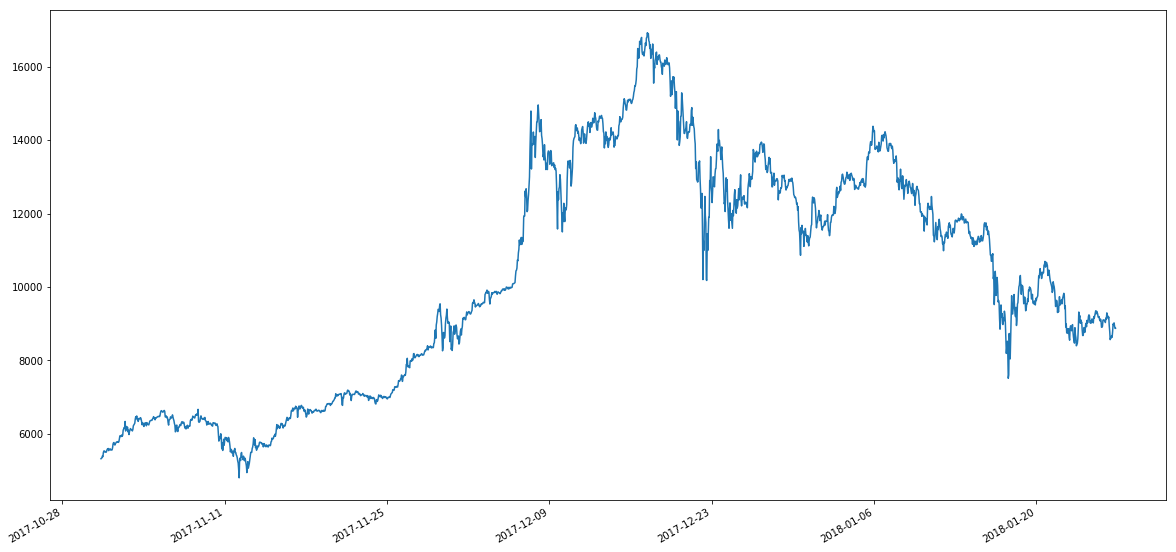

In [35]:
rates = historic_rates('BTC-EUR', 2000, granularity=3600)
prices = [x[4] for x in rates]
while 'a' in prices: prices.remove('a')
times = [x[0] for x in rates]
while 'm' in times: times.remove('m')

prices.reverse()
times.reverse()

print(len(prices))

times_s = pd.Series(times).astype("datetime64[s]")
time_price = pd.Series(prices, times_s)

time_price.plot(figsize=(20,10))
print(prices[-1]/prices[0] * 100)
print(prices[:10])

In [27]:
look_back = 1000
potential = []
print(prices[-1]/prices[-look_back] * 100)

for slow_win in range(10, 30, 5):
    for fast_win in range(5, int(slow_win/2), 2):
        for signal_win in range(1, 10):
            
            ppoAlgo = PPOAlgo(slow_win=slow_win, 
                              fast_win=fast_win, 
                              signal_win=signal_win, 
                              prices=prices[-look_back - slow_win:-look_back])


            trader = Trader(algo=ppoAlgo,
                            verbose=False)
            final = 0
            stance = False
            for price in prices[-look_back:]:
                final, stance = trader.tick(price)
            potential.append((slow_win, fast_win, signal_win, round(final, 2)))
    potential.sort(key=lambda tup: tup[3], reverse=True)
    for sims in potential[:3]:
        print('{}, {}, {} = {}'.format(*sims))

60.155924459146526
15, 5, 1 = 100.0
15, 5, 2 = 62.19
15, 5, 6 = 56.85
15, 5, 1 = 100.0
20, 5, 1 = 100.0
20, 7, 1 = 100.0
15, 5, 1 = 100.0
20, 5, 1 = 100.0
20, 7, 1 = 100.0


In [39]:
look_back = 1000
slow_win=26
fast_win=12
signal_win=9

slow = EMA(slow_win)
fast = EMA(fast_win)
signal = EMA(signal_win)

for price in prices[-look_back - slow_win:-look_back]:
    slow_val = slow.tick(price)
    fast_val = fast.tick(price)
    if slow_val and fast_val:
        signal.tick((fast_val - slow_val) / slow_val)


ppoAlgo = PPOAlgo(slow_win=slow_win, 
                  fast_win=fast_win, 
                  signal_win=signal_win, 
                  prices=prices[-look_back - slow_win:-look_back])


trader = Trader(algo=ppoAlgo,
                verbose=True)
final = 0
stance = False

slows = []
fasts = []
signals = []
stances = []
finals = []
for price in prices[-look_back:]:
    
    final, stance = trader.tick(price)
    slow_val = slow.tick(price)
    fast_val = fast.tick(price)
    signal_val = signal.tick((fast_val - slow_val) / slow_val)
    slows.append(slow_val)
    fasts.append(fast_val)
    signals.append(signal_val)
    stances.append(stance)
    finals.append(final)

0 - Price: 15000.48, Stance: Out, Decision: Buy, Value: 100.0
1 - Price: 15021.64, Stance: In, Decision: Buy, Delta: 0.14, Value: 100.14
2 - Price: 15090, Stance: In, Decision: Buy, Delta: 0.46, Value: 100.6
3 - Price: 15117, Stance: In, Decision: Buy, Delta: 0.18, Value: 100.78
4 - Price: 15189.99, Stance: In, Decision: Buy, Delta: 0.49, Value: 101.26
5 - Price: 15299, Stance: In, Decision: Buy, Delta: 0.73, Value: 101.99
6 - Price: 15348.12, Stance: In, Decision: Buy, Delta: 0.33, Value: 102.32
7 - Price: 15480.01, Stance: In, Decision: Buy, Delta: 0.88, Value: 103.2
8 - Price: 15472.86, Stance: In, Decision: Buy, Delta: -0.05, Value: 103.15
9 - Price: 15542.49, Stance: In, Decision: Buy, Delta: 0.46, Value: 103.61
10 - Price: 15650.97, Stance: In, Decision: Buy, Delta: 0.72, Value: 104.34
11 - Price: 15939, Stance: In, Decision: Buy, Delta: 1.92, Value: 106.26
12 - Price: 15999.99, Stance: In, Decision: Buy, Delta: 0.41, Value: 106.66
13 - Price: 16497.69, Stance: In, Decision: Buy,

461 - Price: 12743.06, Stance: Out, Decision: Sell, Value: 102.03
462 - Price: 12708.01, Stance: Out, Decision: Sell, Value: 102.03
463 - Price: 12693.11, Stance: Out, Decision: Sell, Value: 102.03
464 - Price: 12680.32, Stance: Out, Decision: Sell, Value: 102.03
465 - Price: 12690, Stance: Out, Decision: Sell, Value: 102.03
466 - Price: 12665.54, Stance: Out, Decision: Sell, Value: 102.03
467 - Price: 12740, Stance: Out, Decision: Sell, Value: 102.03
468 - Price: 12757.35, Stance: Out, Decision: Buy, Value: 102.03
469 - Price: 12844.81, Stance: In, Decision: Buy, Delta: 0.7, Value: 102.73
470 - Price: 12769.57, Stance: In, Decision: Buy, Delta: -0.6, Value: 102.13
471 - Price: 12877.5, Stance: In, Decision: Buy, Delta: 0.86, Value: 102.99
472 - Price: 12899, Stance: In, Decision: Buy, Delta: 0.17, Value: 103.16
473 - Price: 12940, Stance: In, Decision: Buy, Delta: 0.33, Value: 103.49
474 - Price: 12850, Stance: In, Decision: Buy, Delta: -0.72, Value: 102.77
475 - Price: 12954.06, Stan

902 - Price: 8859.96, Stance: Out, Decision: Sell, Value: 71.98
903 - Price: 8627.22, Stance: Out, Decision: Sell, Value: 71.98
904 - Price: 8549.97, Stance: Out, Decision: Sell, Value: 71.98
905 - Price: 8880, Stance: Out, Decision: Sell, Value: 71.98
906 - Price: 8941.88, Stance: Out, Decision: Sell, Value: 71.98
907 - Price: 8907.18, Stance: Out, Decision: Buy, Value: 71.98
908 - Price: 8806.45, Stance: In, Decision: Buy, Delta: -0.81, Value: 71.17
909 - Price: 8919.65, Stance: In, Decision: Buy, Delta: 0.91, Value: 72.08
910 - Price: 8974.06, Stance: In, Decision: Buy, Delta: 0.44, Value: 72.52
911 - Price: 8769, Stance: In, Decision: Buy, Delta: -1.66, Value: 70.87
912 - Price: 8631.85, Stance: In, Decision: Buy, Delta: -1.11, Value: 69.76
913 - Price: 8536.26, Stance: In, Decision: Buy, Delta: -0.77, Value: 68.98
914 - Price: 8470, Stance: In, Decision: Buy, Delta: -0.54, Value: 68.45
915 - Price: 8890.01, Stance: In, Decision: Buy, Delta: 3.39, Value: 71.84
916 - Price: 8695, St

[]

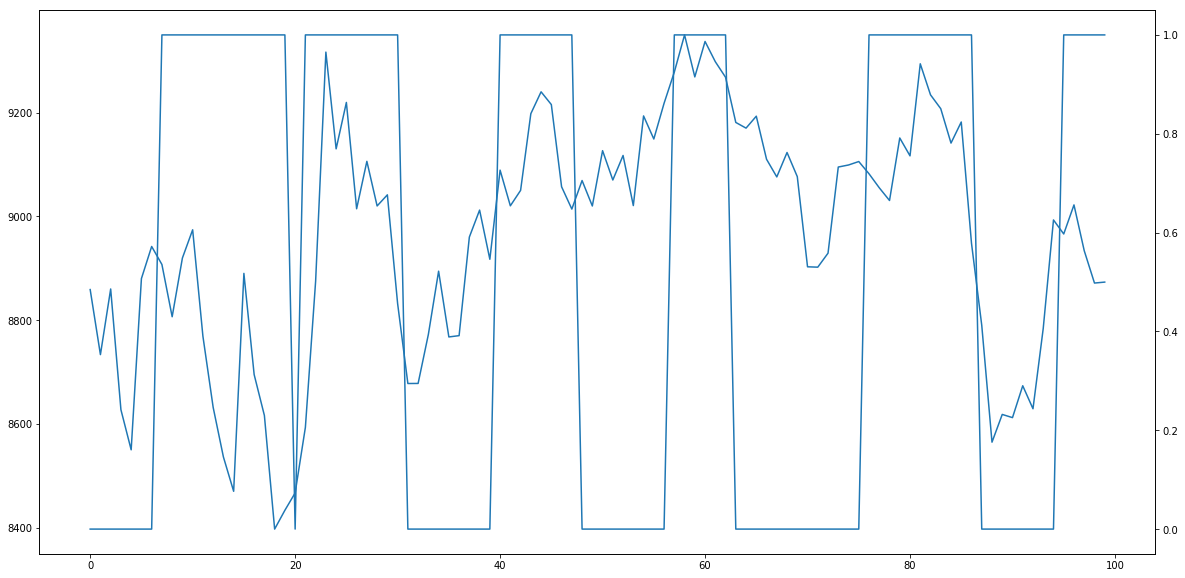

In [43]:
fig, ax1 = plt.subplots(figsize=(20,10))

ax2 = ax1.twinx()
ax1.plot(prices[-100:])
ax2.plot(stances[-100:])
plt.plot()